# Animorphs Authorship Authenticity Analysis

### Ethan Henley

### Notebook 04: Naive Bayes and SVM on Wordcounts

## Alternate Supervised Learning Modeling Process

Because W2V-SVM transfer learning proved insufficient, we ran Naive Bayes and Support Vector Machine classifiers on CountVectorized Animorphs books instead, and found that the wordcount-based SVM was the most accurate predictor on both the corpus as a whole and on individual books. We used the same strategy of leave-one-out validation as before. 

We concluded that, though the Word2Vec-based transfer learning models were not useful for this type of authorship analysis, the count-based SVM was a sufficiently accurate stylometric model.

## Contents
- [Loading](#Loading)
- [Modeling](#Modeling)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)

## Loading

Imports.

In [1]:
import numpy as np

import pandas as pd

from ast import literal_eval

from sklearn.feature_extraction.text import CountVectorizer, \
    TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC

import matplotlib.pyplot as plt

# a small module of functions i wrote for this project:
from small_lib import col_acc, inacc_set, do_gs

Load `chaps_df` and undo array-to-list.

In [2]:
chaps_df = pd.read_csv('../data/animorphs_chaps.csv')

for col in ['clean','clean_no_stops', 'vec_clean']:
    chaps_df[col] = chaps_df[col].map(literal_eval) # as lists
    
for col in ['vec_clean']:
    chaps_df[col] = chaps_df[col].map(np.array) # as array
    
chaps_df.head()

,book,chapter,text,authenticity,clean,clean_no_stops,vec_clean
0,1,1,"My name is Jake. That's my first name, obvious...",1,"[name, thats, first, name, obviously, cant, te...","[my, name, is, jake, thats, my, first, name, o...","[0.050813198, 0.21546867, -0.11217794, 0.05301..."
1,1,2,"""A flying saucer?"" Marco said. He did laugh. T...",1,"[flying, saucer, qstinpunc, laugh, looked, cou...","[a, flying, saucer, qstinpunc, marco, said, he...","[0.0059409393, 0.23846294, -0.09167185, 0.0067..."
2,1,3,<They have come to destroy you.>\nIt was stran...,1,"[anglepunc, come, destroy, anglepunc, strange,...","[anglepunc, they, have, come, to, destroy, you...","[0.00516426, 0.25513598, -0.040639274, -0.0519..."
3,1,4,<Yeerks!>\nThe twin red lights slowed. They tu...,1,"[anglepunc, yeerks, exclmpunc, anglepunc, twin...","[anglepunc, yeerks, exclmpunc, anglepunc, the,...","[-0.027513022, 0.24088845, 0.00715725, -0.0299..."
4,1,5,"The Hork-Bajir pointed his gun, or whatever it...",1,"[hork, odashpunc, bajir, pointed, gun, whateve...","[the, hork, odashpunc, bajir, pointed, his, gu...","[-0.037028935, 0.29484826, 0.030976577, -0.076..."


Load `books_df` and undo array-to-list.

In [3]:
books_df = pd.read_csv('../data/animorphs_books.csv')

for col in ['clean','book_vec']:
    books_df[col] = books_df[col].map(literal_eval) # as lists
    
for col in ['book_vec']:
    books_df[col] = books_df[col].map(np.array) # as array
    
books_df.head()

,book,text,authenticity,clean,book_vec
0,1,"My name is Jake. That's my first name, obvious...",1,"[name, thats, first, name, obviously, cant, te...","[0.0010895184, 0.2081184, -0.05931624, 0.01286..."
1,2,My name is Rachel. I won't tell you my last na...,1,"[name, tell, last, name, none, us, ever, tell,...","[-0.00226549, 0.22271992, -0.065148115, 0.0113..."
2,3,My name is Tobias. A freak of nature. One of a...,1,"[name, freak, nature, kind, tell, last, name, ...","[-0.0129256295, 0.21558568, -0.05230921, 0.003..."
3,4,My name is Cassie.\nI can't tell you my last n...,1,"[name, cant, tell, last, name, wish, could, ca...","[-0.0025382496, 0.21817772, -0.069260634, 0.00..."
4,5,My name is Marco.\nI can't tell you my last na...,1,"[name, cant, tell, last, name, live, believe, ...","[-0.00024333985, 0.22410813, -0.054545447, 0.0..."


Load W2V results.

In [4]:
old_results = pd.read_csv('../data/results.csv')

old_results.head()

,book,w2vsvm book pred proba,w2vsvm chap pred avg,w2vsvm chap pred proba avg,authenticity
0,1,0.991171,0.925926,0.740572,1
1,2,0.972882,0.869565,0.729202,1
2,3,0.978186,0.777778,0.720986,1
3,4,0.973608,0.920000,0.730618,1
4,5,0.988004,0.875000,0.796461,1


## Word Count Vectors

Because the Word2Vec-based model did not return ideal results, we instead will try methods that do not attempt to interpret the contexts or meanings of words. This will hopefully allow models to better pick up on style.

Our simpler options for word vectorization are CountVectorizer, which returns straightforward word counts, and TFIDFVectorizer, which scales based on term frequency times the inverse document frequency. 

In [6]:
def cvec_all(df, col, max_features=100):
    cvec = CountVectorizer(max_features=max_features)
    return pd.DataFrame(cvec.fit_transform(df[col].map(' '.join)).toarray(),
                        columns=cvec.get_feature_names())

def tvec_all(df, col, max_features=100):
    tvec = TfidfVectorizer(max_features=max_features)
    return pd.DataFrame(tvec.fit_transform(df[col].map(' '.join)).toarray(),
                        columns=tvec.get_feature_names())

## Modeling

Random state for SVM.

In [5]:
seed = 1007

We'll use similar functions to those we used for the W2V SVM to do leave-one-out analysis to maximize the training data available when checking each book. We could not use the exact same code, as this set of models is taking in a different type of word vector stored in a different format.

In [7]:
max_features = 500

In [8]:
def p1o_book(book_out, model, params, books_df=books_df): # predict 1 out

    train_inds = books_df['book'] != book_out
    test_inds = books_df['book'] == book_out
    
    vec_df = cvec_all(books_df, 'clean', max_features=max_features)
    
    X_b = vec_df.loc[train_inds]
    y_b = books_df['authenticity'].loc[train_inds]
    
    X_b_test = vec_df.loc[test_inds]

    model = do_gs(model, params, X_b, y_b)
    return (model.predict(X_b_test), model.predict_proba(X_b_test)[:,1])

In [9]:
def p1o_chap(book_out, model, params, chaps_df=chaps_df): # predict 1 out

    train_inds = chaps_df['book'] != book_out
    test_inds = chaps_df['book'] == book_out
    
    vec_df = cvec_all(chaps_df, 'clean', max_features=max_features)
    
    X_c = vec_df.loc[train_inds]
    y_c = chaps_df['authenticity'].loc[train_inds]
    
    X_c_test = vec_df.loc[test_inds]
    
    model = do_gs(model, params, X_c, y_c)
#     print(f'book {book_out} complete')
    return (np.mean(model.predict(X_c_test)), 
            np.mean(model.predict_proba(X_c_test)[:,1]))

Establish some parameters to search over for the types of models we'll run: Naive Bayes and Support Vector Machine. These are the two most common supervised models in stylometric NLP, and each are well-proven on the types of data that our word vectorizers will offer.

In [10]:
mnb_params = {'alpha':np.logspace(-3,0,4)}
mnb = MultinomialNB()

# gnb_params = {}
# gnb = GaussianNB()

svm_params = {
    'C':np.logspace(2,4,5),
    'kernel':['rbf']
}
svm = SVC(random_state=seed, gamma='scale',
          max_iter=5e4, probability=True)

Generate Results

In [11]:
new_results = pd.DataFrame({'book':range(1,55)})
new_results['mnb book pred'] = new_results['book'].map(
    lambda b:p1o_book(b, mnb, mnb_params)[0][0])
new_results['mnb chap pred avg'] = new_results['book'].map(
    lambda b:p1o_chap(b, mnb, mnb_params)[0])
new_results['svm book pred proba'] = new_results['book'].map(
    lambda b:p1o_book(b, svm, svm_params)[1][0])
new_results['svm chap pred proba avg'] = new_results['book'].map(
    lambda b:p1o_chap(b, svm, svm_params)[1])
new_results['authenticity'] = books_df['authenticity']

In [12]:
old_results.head()

,book,w2vsvm book pred proba,w2vsvm chap pred avg,w2vsvm chap pred proba avg,authenticity
0,1,0.991171,0.925926,0.740572,1
1,2,0.972882,0.869565,0.729202,1
2,3,0.978186,0.777778,0.720986,1
3,4,0.973608,0.920000,0.730618,1
4,5,0.988004,0.875000,0.796461,1


We cannot visualize all of these outcomes in the way we did the previous, as the Naive Bayes models do not return meaningful probabilities. 

In [13]:
new_results.head()

,book,mnb book pred,mnb chap pred avg,svm book pred proba,svm chap pred proba avg,authenticity
0,1,1,0.814815,1.000000,0.878420,1
1,2,1,0.869565,1.000000,0.890153,1
2,3,1,0.888889,0.953823,0.864677,1
3,4,1,0.840000,0.991939,0.778279,1
4,5,1,0.875000,0.952473,0.816749,1


## Model Evaluation

Combine result tables.

In [14]:
results = pd.concat(
    [old_results.drop(columns='authenticity'),
     new_results.drop(columns='book')],
    axis=1)
results.head()

,book,w2vsvm book pred proba,w2vsvm chap pred avg,w2vsvm chap pred proba avg,mnb book pred,mnb chap pred avg,svm book pred proba,svm chap pred proba avg,authenticity
0,1,0.991171,0.925926,0.740572,1,0.814815,1.000000,0.878420,1
1,2,0.972882,0.869565,0.729202,1,0.869565,1.000000,0.890153,1
2,3,0.978186,0.777778,0.720986,1,0.888889,0.953823,0.864677,1
3,4,0.973608,0.920000,0.730618,1,0.840000,0.991939,0.778279,1
4,5,0.988004,0.875000,0.796461,1,0.875000,0.952473,0.816749,1


In [15]:
results.to_csv('../data/results_u.csv', index=False)

Check models' accuracy.

In [16]:
print('Accuracy Scores:') # rounds proba to 0 or 1 for determining accuracy
{col:col_acc(results, col) 
 for col in results.columns 
 if col not in ['book','authenticity']}

Accuracy Scores:


{'w2vsvm book pred proba': 0.8518518518518519,
 'w2vsvm chap pred avg': 0.8703703703703703,
 'w2vsvm chap pred proba avg': 0.8703703703703703,
 'mnb book pred': 0.9259259259259259,
 'mnb chap pred avg': 0.8703703703703703,
 'svm book pred proba': 0.962962962962963,
 'svm chap pred proba avg': 0.9259259259259259}

The high accuracy of the non-W2V Support Vector Machine classifier is encouraging, but we must ensure that it does not struggle with 'out of place' books the way the other models. do.

In [17]:
print('Which books did each method get wrong?')
wrongs = {col:inacc_set(results, col) 
          for col in results.columns 
          if col not in ['book','authenticity']}
wrongs

Which books did each method get wrong?


{'w2vsvm book pred proba': {24, 25, 26, 34, 48, 50, 53, 54},
 'w2vsvm chap pred avg': {25, 26, 29, 34, 50, 53, 54},
 'w2vsvm chap pred proba avg': {25, 28, 29, 34, 50, 53, 54},
 'mnb book pred': {13, 25, 34, 53},
 'mnb chap pred avg': {25, 27, 28, 34, 43, 48, 53},
 'svm book pred proba': {13, 18},
 'svm chap pred proba avg': {25, 28, 31, 34}}

Interestingly, the SVM on CountVectorized entire books accurately assesses the books expected to be challenging (25, 26, 32, 53, and 54) as well as one that most other models confusingly struggled with (34). It errs twice on books that nearly every other method correctly predicted, but still results in a high accuracy. For this reason, I am confident selecting the CountVectorizer Support Vector Machine classifier as our recommended model.

We'll develop a plot similar to before to compare the predictions of each model.

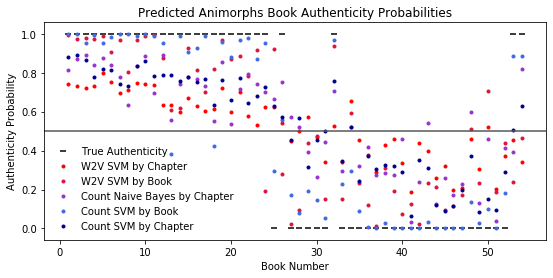

In [18]:
plt.figure(figsize=(9,4))
plt.axhline(.5,c='#555555')
plt.scatter(range(1,55), results['authenticity'],
            c='k', marker='_', label='True Authenticity')
plt.scatter(range(1,55), results['w2vsvm chap pred proba avg'],
            c='r', marker='.', label='W2V SVM by Chapter')
plt.scatter(range(1,55), results['w2vsvm book pred proba'], 
            c='crimson', marker='.', label='W2V SVM by Book')
plt.scatter(range(1,55), results['mnb chap pred avg'],
            c='darkorchid', marker='.', 
            label='Count Naive Bayes by Chapter')
plt.scatter(range(1,55), results['svm book pred proba'],
            c='royalblue', marker='.', label='Count SVM by Book')
plt.scatter(range(1,55), results['svm chap pred proba avg'],
            c='darkblue', marker='.', label='Count SVM by Chapter')

plt.legend(fancybox=True, framealpha=0)
plt.title('Predicted Animorphs Book Authenticity Probabilities')
plt.xlabel('Book Number')
plt.ylabel('Authenticity Probability')
plt.savefig('../figures/all_results.png');

There's a lot of information conveyed there, but it may be easier to read if we just compare our final choice, the count-based book SVM, against an analogous baseline, the W2V book SVM. 

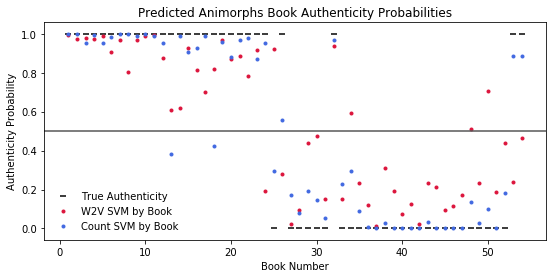

In [19]:
plt.figure(figsize=(9,4))
plt.axhline(.5,c='#555555')
plt.scatter(range(1,55), results['authenticity'],
            c='k', marker='_', label='True Authenticity')
plt.scatter(range(1,55), results['w2vsvm book pred proba'], 
            c='crimson', marker='.', label='W2V SVM by Book')
plt.scatter(range(1,55), results['svm book pred proba'],
            c='royalblue', marker='.', label='Count SVM by Book')

plt.legend(fancybox=True, framealpha=0)
plt.title('Predicted Animorphs Book Authenticity Probabilities')
plt.xlabel('Book Number')
plt.ylabel('Authenticity Probability')
plt.savefig('../figures/limited_results.png');

Unlike our Word2Vec-based models, the count-based SVM doesn't seem to predict lower probabilities over time within the non-ghostwritten first 24 books—it drops immediately at 25, pulls up at 26, and gets all that follow right. It does not percieve or get distracted by the content shift that decieved the W2V models, instead adhering more closely to pure style. It does curiously misclassify two early authentic books that most other models correctly predicted; however, were one to set the probability threshold low enough to meet these, one would have 100% accuracy. That this would even be necessary is an artifact of our leave-one-out methodology, but it signifies that our model is sufficient.

## Conclusion

It is somewhat disappointing that our Word2Vec-based model was outperformed by a simpler count-based model, but not every tool fits every task, and this is evidence that might help resolve disputes over its relevance to stylometry at large. 

That established, our count-based model was effective and accurate, and were a 55th canonical Animorphs book released today in the style of the 54 that preceded and with its authenticity unknown, we believe that the model would be well-suited to assess its authorship.

The Animorphs corpus may be an especially challenging problem for stylometry and authorship detection—it is a series of books with related but progressing content with authorship split mostly sequentially which was edited for consistency by the listed author even when she did not write a book. That an authorship detection model such as this can be established with high accuracy is a testament to the power of natural language processing, even without the involvement of neural networks. 

Many experiments in stylometry use standard, historic corpuses such as 'great' novels, the Federalist Papers, or the works of Shakespeare, but these corpuses are not representative of the diversity of English writing. We recommend that less formal writing—internet posts, film and television scripts, and yes, even children's and middle-grade book series—also be used as standards against which to assess stylometric techniques, and hope that this project shows that sylometry on informal writing can offer unique insights.